In [1]:
import json
import matplotlib.pyplot as plt

from collections import Counter
import numpy as np

%matplotlib inline

## Tag prediction task - EDA

This document is for getting some insights about the distributions of tags, their popularity in the community and within the dataset.

I am aiming to answer the following questions:

#### 1) how many tags should we use for benchmarking multi-label classification task?

Answer: most likely 3, but it's interesting to compare with 2 and 4 and see how much influence in will have on precision and recall

#### 2) how strong is the imbalance?

Answer: hella strong

#### 3) can we extract certain groups of tags based on their co-occurence?

Answer: 

#### 4) What should be the procedure for building a weakly supervised dataset? 

Answer: we obviously need to take into account the distribution of tags' usage. Discarding 99%+ of labels will lead to eliminating of most of the important tags leaving us with super rare stuff that we don't encounter in both train and test sets. 
So, to do it right, we need 

    1) Choose top N popular tags that will participate in the experiment
    
    2) Discard the rest from the whole dataset
    
    3) Build a fully supervised model for reference
    
    4) Build several weakly supervised datasets 
    
In this process we will have a lot of documents that don't have any labels no matter what we discard. They will be used for unsupervised pretraining and building synthetic labels. 

#### 5) What's the procedure for comparing fully supervised classification models?

Answer: I don't think we should discard anything, let's just roll with what we have and compare performance on all labels. 

In [2]:
# this should point to the main json file
data_src = '../../../data/medium/medium.json'

In [3]:
def gen_obj(path):
    with open(path) as f:
        for line in f:
            yield json.loads(line)

In [4]:
tag_names = []
n_tags = []
tag_subs = {}
tag_sets = []

for i, obj in enumerate(gen_obj(data_src)):
    t = obj['tags']
    n_tags.append(len(t))
    tag_sets.append([])
    for q in t:
        tag_subs[q['name']] = q['followerCount']
        tag_names.append(q['name'])
        tag_sets[i].append(q['name'])
count = Counter(tag_names)
print('{} tags total, {} unique tags'.format(len(tag_names), len(count)))

tags_by_followers = sorted([(t, tag_subs[t]) for t in set(tag_names)], key=lambda t: -t[1])
tags_by_usage = sorted([(t, count[t]) for t in set(tag_names)], key=lambda t: -t[1])

4732611 tags total, 248502 unique tags


20 most used tags:
Startup: 49946
Travel: 40254
Politics: 38060
Life: 34932
Life Lessons: 33003
Design: 32734
Entrepreneurship: 31361
Education: 26980
Health: 26613
Writing: 23620
Music: 23540
Tech: 23413
Poetry: 23288
Love: 23269
Marketing: 21706
Social Media: 20283
Technology: 18751
Sports: 17977
Photography: 17407
Food: 16577


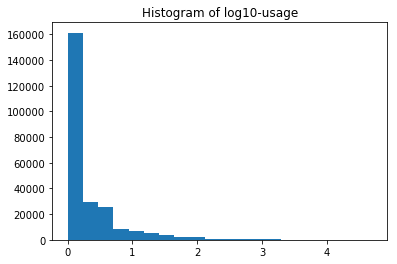

In [5]:
print('20 most used tags:')

for tag, c in tags_by_usage[:20]:
    print('{}: {}'.format(tag, c))
    
plt.hist(np.log10(list(count.values())), bins=20)
plt.title('Histogram of log10-usage')
plt.show()

20 most followed tags:

Design: 933785
Tech: 857647
Creativity: 831605
Travel: 770996
Technology: 769456
Humor: 747946
Self Improvement: 697454
Inspiration: 687484
Innovation: 676270
Business: 671076
Writing: 652439
Social Media: 646997
Photography: 638933
Life: 627827
Life Lessons: 589983
Startup: 584065
Entrepreneurship: 583686
Productivity: 545010
Movies: 542680
Politics: 540826


20 least followed tags:

Korea Trip: 0
Hsk Test: 0
The Goonies: 0
Cicloviagens Na Bolívia: 0
Enrique Cerdán Tato: 0
Tire: 0
Subscription Revenue: 0
Soba: 0
Ge2016: 0
Branding Emails: 0
Dentzzreview: 0
Cet: 0
Inkshares Contest: 0
Evc Ventures: 0
Badge: 0
Embrace Change: 0
Uninstall Bittorrent: 0
Ctools: 0
Ted Bundy: 0
Shopping Spree: 0


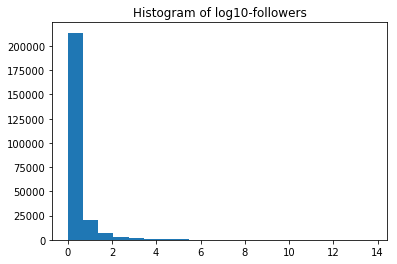

In [6]:
print('20 most followed tags:\n')

for tag, c in tags_by_followers[:20]:
    print('{}: {}'.format(tag, c))
    
print('\n')
    
print('20 least followed tags:\n')

for tag, c in tags_by_followers[-20:]:
    print('{}: {}'.format(tag, c))
    
plt.hist(np.log1p([x[1] for x in tags_by_followers]), bins=20)
plt.title('Histogram of log10-followers')
plt.show()

#### Analysis

So, the first insight here is that there are LOTS of tags that have been used, but they are not established topics in the sense that they don't have followers. We can test this by plotting the number of occurences versus the number of followers for every tag.

In [7]:
tbf = dict(tags_by_followers)
tbu = dict(tags_by_usage)

In [8]:
points = np.zeros((len(tbf.keys()), 2))
for i, k in enumerate(tbf):
    points[i] = np.array([tbu[k], tbf[k]])

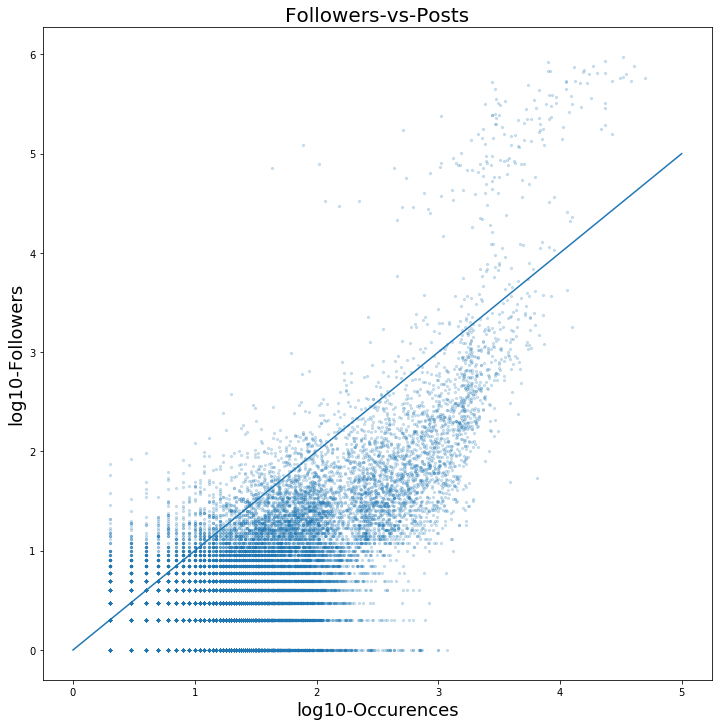

In [9]:
plt.figure(figsize=(12, 12))
plt.scatter(np.log10(1. + points[:, 0]), np.log10(1. + points[:, 1]), s=5, alpha=0.2)
plt.plot(np.linspace(0, 5, 1000), np.linspace(0, 5, 1000)) #simple linear trend
plt.xlabel('log10-Occurences', fontsize=18)
plt.ylabel('log10-Followers', fontsize=18)
plt.title('Followers-vs-Posts', fontsize=20)
plt.show()

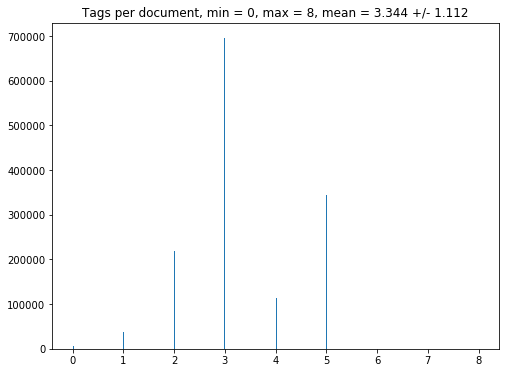

In [10]:
plt.figure(figsize=(8, 6))
plt.hist(n_tags, bins='auto')
plt.title('Tags per document, min = {0}, max = {1}, mean = {2:0.3f} +/- {3:0.3f}'.format(
    np.min(n_tags), np.max(n_tags), np.mean(n_tags), np.std(n_tags)))
plt.show()

I think, if we go with 3, it'll be fine. Anyway, it will be rather trivial to report the scores on 2 and 4 labels as well. 

### Choosing the number of tags

In [11]:
tags = np.array([x[0] for x in tags_by_usage])
occurencies = np.array([x[1] for x in tags_by_usage])

def cutoff_tags(tagsets, tags, occ, th):
    empty = 0
    nonempty = 0
    ind = np.where(occ >= th)[0]
    filtered_tags = set(tags[ind].tolist())
    for doc in tagsets:
        is_empty = True
        for t in doc:
            if t in filtered_tags:
                is_empty = False
                break
        if is_empty:
            empty += 1
        else:
            nonempty += 1
    return float(nonempty) / len(n_tags), ind.shape[0]

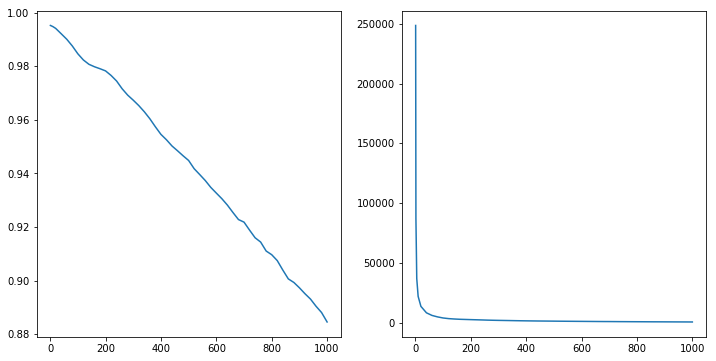

(1, 0.9952412080010459, 248502)
(2, 0.9952009271658899, 87260)
(5, 0.9950595909021847, 37147)
(10, 0.9948157858472932, 22289)
(20, 0.9941522120891974, 13933)
(40, 0.9921395836940352, 8553)
(60, 0.9900986880461321, 6368)
(80, 0.9875935027719575, 5147)
(100, 0.9846685487945783, 4245)
(120, 0.982362647652228, 3709)
(140, 0.9807492942020332, 3389)
(160, 0.9798313151692678, 3153)
(180, 0.9790921265100896, 3010)
(200, 0.9782872164882885, 2863)
(220, 0.9765848211919593, 2729)
(240, 0.9744979912583521, 2595)
(260, 0.9716048379403066, 2448)
(280, 0.969235335479289, 2333)
(300, 0.9673569765346468, 2238)
(320, 0.965336574644981, 2161)
(340, 0.9630349135905418, 2082)
(360, 0.9604173659867214, 1994)
(380, 0.9574146770643045, 1915)
(400, 0.954588658471519, 1842)
(420, 0.952566843219216, 1784)
(440, 0.9502510485384064, 1726)
(460, 0.9484574913519873, 1683)
(480, 0.9465953860776714, 1640)
(500, 0.9448392830011342, 1597)
(520, 0.9417715793974129, 1546)
(540, 0.9395921742110787, 1507)
(560, 0.9373668347

In [12]:
thresholds = [1, 2, 5, 10] + [20 * x for x in range(1, 51)]
perc = []
counts = []
for th in thresholds:
    _p, _c = cutoff_tags(tag_sets, tags, occurencies, th)
    perc.append(_p)
    counts.append(_c)
    
fig, ax = plt.subplots(1,2, figsize=(12, 6), sharey=False, sharex=True)
ax[0].plot(thresholds, perc)

ax[1].plot(thresholds, counts)
plt.show()
for k in list(zip(thresholds, perc, counts)):
    print(k)

We can set the threshold up to 860 retaining at least 90% of documents. 

Now let's take a look at the histogram of the tag numbers after filtering

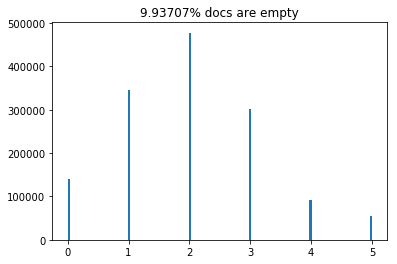

In [16]:
th = 860
ind = np.where(occurencies >= th)[0]
filtered_tags = set(tags[ind].tolist())
n_tags_filt = []
for doc in tag_sets:
    k = len([t for t in doc if t in filtered_tags])
    n_tags_filt.append(k)
n_tags_filt = np.array(n_tags_filt)
plt.hist(n_tags_filt, bins='auto')
plt.title('{0:0.5f}% docs are empty'.format(np.where(n_tags_filt == 0)[0].shape[0] / n_tags_filt.shape[0] * 100))
plt.show()

Therefore, after this filtering preferable number of labels for predictions is reduced to 2, which is going to be a rather important detail during the analysis.